<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Log</a></span></li><li><span><a href="#To-do" data-toc-modified-id="To-do-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>To do</a></span></li><li><span><a href="#Musings" data-toc-modified-id="Musings-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Musings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Create-dls" data-toc-modified-id="Create-dls-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create dls</a></span></li></ul></li><li><span><a href="#Basic-SSD" data-toc-modified-id="Basic-SSD-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic SSD</a></span><ul class="toc-item"><li><span><a href="#Architecture" data-toc-modified-id="Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Loss</a></span></li><li><span><a href="#Viewing-data-&amp;-results" data-toc-modified-id="Viewing-data-&amp;-results-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Viewing data &amp; results</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Train</a></span></li></ul></li><li><span><a href="#Results-for-basic-SSD" data-toc-modified-id="Results-for-basic-SSD-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Results for basic SSD</a></span></li></ul></li><li><span><a href="#More-Boxes!" data-toc-modified-id="More-Boxes!-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More Boxes!</a></span><ul class="toc-item"><li><span><a href="#Old-code" data-toc-modified-id="Old-code-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Old code</a></span><ul class="toc-item"><li><span><a href="#Old-architecture" data-toc-modified-id="Old-architecture-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Old architecture</a></span></li><li><span><a href="#Old-loss" data-toc-modified-id="Old-loss-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Old loss</a></span></li></ul></li><li><span><a href="#New-code" data-toc-modified-id="New-code-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>New code</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Does-torch.cat-work-as-intended?-(Answer-looks-like-yes)." data-toc-modified-id="Does-torch.cat-work-as-intended?-(Answer-looks-like-yes).-4.2.0.1"><span class="toc-item-num">4.2.0.1&nbsp;&nbsp;</span>Does torch.cat work as intended? (Answer looks like yes).</a></span></li><li><span><a href="#Investigating-Architecture" data-toc-modified-id="Investigating-Architecture-4.2.0.2"><span class="toc-item-num">4.2.0.2&nbsp;&nbsp;</span>Investigating Architecture</a></span></li></ul></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Init-anchors" data-toc-modified-id="Init-anchors-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Init anchors</a></span></li><li><span><a href="#Init-model-&amp;-train" data-toc-modified-id="Init-model-&amp;-train-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Init model &amp; train</a></span></li></ul></li><li><span><a href="#Results-for-more-boxes" data-toc-modified-id="Results-for-more-boxes-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Results for more boxes</a></span></li></ul></li><li><span><a href="#Focal-Loss" data-toc-modified-id="Focal-Loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Focal Loss</a></span><ul class="toc-item"><li><span><a href="#New-code" data-toc-modified-id="New-code-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>New code</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Init-anchors" data-toc-modified-id="Init-anchors-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Init anchors</a></span></li><li><span><a href="#Init-model-&amp;-train" data-toc-modified-id="Init-model-&amp;-train-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Init model &amp; train</a></span></li></ul></li><li><span><a href="#Results-for-focal-loss" data-toc-modified-id="Results-for-focal-loss-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Results for focal loss</a></span></li></ul></li></ul></div>

# Summary

Diving deep into DL4C 2018 lesson 9 to implement SSD object detection ([link to the video here](https://www.youtube.com/watch?v=0frKXR-2PBY)).

## Log

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.
- 2020-11-05 (Thurs): Discovered bug in reading from pickled dataframe that was causing multilabel tensors to be created as float dtype instead of int dtype.
- 2020-11-06 (Fri): It's working! I got it working last night, but today I looked at the results, and they totally make sense! Still a few things to do, but this is a great result.
- 2020-11-11 (Wed): Over the past few days I cleaned up the nb, added focal loss, non-max suppression, the ResultShower class, and exported some pickled models.

## To do

- Implement Jeremy's 30 epoch training regimen (1:51:26)
    - multiple lrs
    - 10 epochs
    - freeze_to(-2); 10 more epochs @ lrs/4
    - unfreeze(); 10 more epochs @ lrs/16

## Musings

**The anchor box approach**

The idea is to subdivide the image into chunks so we can essentially do many single bbox learners instead of one big multibox. To do this, each image must be subdivided into a grid (or multiple grids), and the labels must be remapped to individual grid cells.

Subdivide the image into cells with a grid. For each cell, generate any number of boxes from it so long as those boxes do not have a higher IOU between them and any other grid cell – the generated boxes must be able to be traced back to their grid cell via IOU. For each box generated, have it perform a 'single labeled bbox' task. Each box generated will produce one result. Keep only the most confident results & prune out any that overlap excessively.

# Data

## Create dls

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
valid_pct  = .10
subset_pct = .3

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*subset_pct)]
dls = db.dataloaders(subset)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 32999
Size of valid data: 3666
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 22, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 22])


# Basic SSD

## Architecture

In [ ]:
def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class StdConv(Module):
    # (42:00) Wraps together the standard conv2d → batchnorm → dropout.
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

class OutConv(Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
#     def forward(self, x):
#         return [self.oconv1(x),
#                 self.oconv2(x)]

    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSD_Head(Module):
    # Wraps StdConv and OutConv into a head module.
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

class Custom_Module(Module):
    # Simple class for joining a body and a head.
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

## Loss

In [ ]:
### Create Anchors ###
def create_anchors(k=1, subdivs=4, device='cuda'):
    box_size = 1/subdivs
    anc_offset = box_size*.5
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_hws = np.array([[box_size,box_size] for i in range(subdivs**2)])
    anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
    box_size = tensor(np.array([box_size]), requires_grad=False).unsqueeze(1)
    return anchors.to(device), box_size.to(device)
def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1


### BCE and MAE Loss Functions ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCE_Loss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None


### IOU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union


### SSD Loss ###
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return create_anchor_boxes(ctrs, hws)
def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs
def ssd_item_loss(act_bb, act_lbl, bb, lbl):
    # 1:11:30
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx] 
    return (bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx]),
           lbl_loss(act_lbl,               targ_lbl))
def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*acts, bbs, lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

## Viewing data & results

In [ ]:
def show_bb(im, bb, lbl, sz=im_size, figsz=5, color='white', ctx=None, title=None):
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:       show_image(im, figsize=[figsz,figsz], title=title, ctx=ctx)
    else:   ctx = show_image(im, figsize=[figsz,figsz], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2-x1, y2-y1)
    v, idx = scores.sort(0) # sort asc
    idx = idx[-top_k:] # idxs of the top-k lrgst vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()
    
    count = 0
    while idx.numel() > 0:
        i = idx[-1] # idx of current lrgst val
        keep[count] = i
        count+=1
        if idx.size(0) == 1: break
        idx = idx[:-1] # remove kept element from view
        # load bboxes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, min=x2[i])
        yy2 = torch.clamp(yy2, min=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2... after each iter
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        iou = inter/union
        idx = idx[iou.le(overlap)]
    return keep, count

In [ ]:
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        self.dls,self.mod,self.ancs,self.anc_sz = dls,lrn.model,ancs,anc_sz
        self.batch    = next(iter(dls.cpu().valid))
        self.dls.cuda()
        self.acts     = self.mod.cpu()(self.batch[0])
        self.mod.cuda()
        self.acts     = [a.data for a in self.acts]
        self.im_size  = self.batch[0].shape[-1]
        self.last_res = 0
        
    def __call__(self, *args, **kwargs):
        return self.show_results(*args, **kwargs)
        
    def show_results(self, n, overlap=.5, conf=.1, figsz=8, use_nms=True):
        b_ims,b_bbs,b_lbls = self.batch
        act_bbs,act_lbls = self.acts
    
        for i in range(n):
            idx=self.last_res+i

            # grab im, targ, acts
            im = self.dls.decode(self.batch)[0][idx]
            bb  = b_bbs[idx]
            lbl = b_lbls[idx]
            act_bb  = act_bbs[idx]
            act_lbl = act_lbls[idx]

            # convert acts to preds
            pred_bb = adjust_anchor_boxes(act_bb,self.ancs,self.anc_sz)
            pred_lbl = act_lbl.max(1)[1]
            lbl_conf = act_lbl.max(1)[0].sigmoid().data

            # nms
            if use_nms:
                nms_idxs, nms_n = nms(pred_bb.data, lbl_conf, overlap)
                nms_idxs = nms_idxs[:nms_n]
                pred_bb  = pred_bb[nms_idxs]
                pred_lbl = pred_lbl[nms_idxs]
                lbl_conf = lbl_conf[nms_idxs]

            # filter out bg and low-conf w/ mask
            is_not_bg = (pred_lbl!=0)
            is_confident = lbl_conf > conf
            mask = is_not_bg & is_confident
            pred_bb = pred_bb[mask]
            pred_lbl = pred_lbl[mask]

            # show pred
            ctx = get_grid(2, figsize=[figsz,figsz])
            show_bb(im, bb, dls.vocab[lbl], sz=self.im_size, ctx=ctx[0]);
            show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=self.im_size,
                    color='magenta', ctx=ctx[1]);
        self.last_res+=n

## Training

### Init

In [ ]:
anchors, box_size = create_anchors()
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])
k=1

In [ ]:
# head_reg4 = SSD_Head(k, -3.)
# body = create_body(resnet34, pretrained=True)
# mod = Custom_Module(body, head_reg4)
# bb_loss = mae
# lbl_loss = BCE_Loss(len(dls.vocab))
# learner = Learner(dls, mod, loss_func = ssd_loss)
# learner.freeze()
# learner.lr_find()

### Train

In [ ]:
# learner.fit_one_cycle(3,lr=3e-4)

epoch,train_loss,valid_loss,time
0,29.185543,30.043684,02:15
1,25.842882,25.691105,02:16
2,23.372749,24.018478,02:17


In [ ]:
# learner.unfreeze()

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=1.737800812406931e-05)

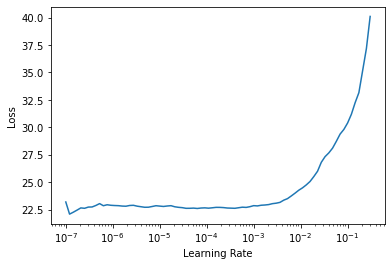

In [ ]:
# learner.lr_find()

In [ ]:
# learner.save('basic')

Path('models/basic.pth')

In [ ]:
# learner.fit_one_cycle(3,lr=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,time
0,25.751390,26.342484,02:15
1,23.541817,24.339045,02:16
2,21.109291,23.489491,02:16


In [ ]:
# learner.export('models/20201112_coco_simple_ssd.pkl')

## Results for basic SSD

In [ ]:
basic_learner = load_learner('models/20201112_coco_simple_ssd.pkl')
basic_results = ResultShower(dls, basic_learner, anchors.cpu(), box_size.cpu())

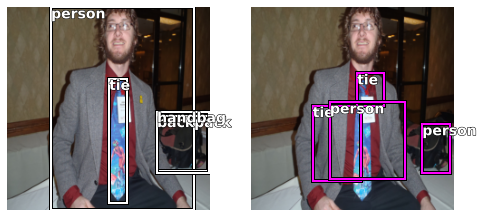

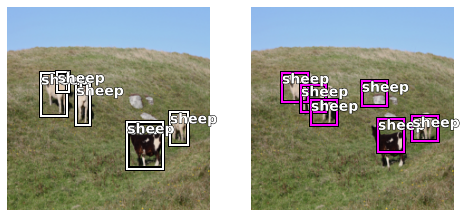

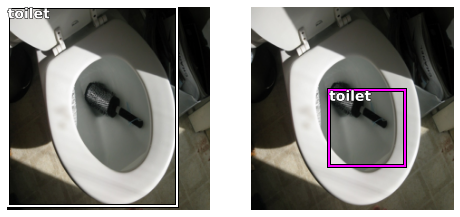

In [ ]:
basic_results(3, use_nms=False)

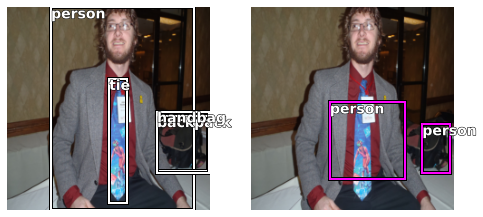

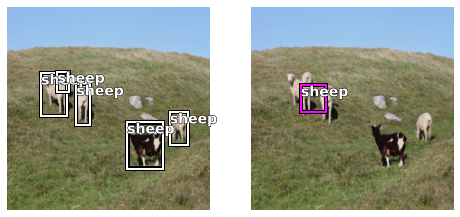

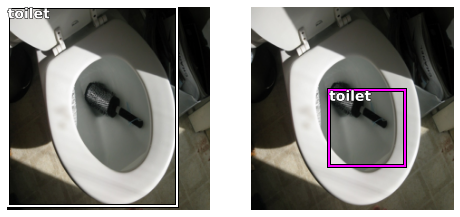

In [ ]:
basic_results.last_res = 0
basic_results(3, use_nms=True)

# More Boxes!

## Old code

### Old architecture

In [ ]:
def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)
class StdConv(Module):
    # (42:00) Wraps together the standard conv2d → batchnorm → dropout.
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
class OutConv(Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_conv  = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.lbl_conv = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.lbl_conv.bias.data.zero_().add_(bias)

#     def forward(self, x):
#         return [flatten_conv(self.bb_conv(x),  self.k),
#                 flatten_conv(self.lbl_conv(x), self.k)]
        
    def forward(self, x): return [self.bb_conv(x), self.lbl_conv(x)]
# ssd_head replaced
class Custom_Module(Module):
    # Simple class for joining a body and a head.
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

### Old loss

In [ ]:
### Anchors ###
# create_anchors replaced
# create_anchor_boxes replaced

### BCE and MAE Loss Functions ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCE_Loss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None

### IOU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union

### SSD Loss ###
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def hw_to_bb(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1
def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb)                      # scale acts between -1 and 1
    ctrs = anchors[:,:2] + (acts[:,:2]/2*box_size) # move ctrs by up to half a cell length
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)        # scale hws by up to half
    return hw_to_bb(ctrs, hws)
def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs
def ssd_item_loss(act_bb, act_lbl, bb, lbl):
    # 1:11:30
    bb, lbl = remove_padding(bb, lbl)                        # remove padding
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size) # adjust output boxes
    ious = get_iou(bb.data, anchor_boxes.data)               # get
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx] 
    return (bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx]),
           lbl_loss(act_lbl,               targ_lbl))
def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*acts, bbs, lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

## New code

- Create anchors using zooms and ratios (before we were using one zoom and one ratio – the "trivial" do-nothing ones)
- Create new grids of different sizes in the ssd_multihead

In [ ]:
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) 
                          for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)

class SSD_MultiHead(Module):
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        self.conv0 = StdConv(512,256, drop=drop)
        self.out0  = OutConv(k,  256, bias)
        
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        
        self.conv2 = StdConv(256,256, drop=drop)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
#         return [torch.cat([o1c,o2c,o3c], dim=1),
#                 torch.cat([o1l,o2l,o3l], dim=1)]
        return [[bb0,bb1,bb2], [lbl0,lbl1,lbl2]]

#### Does torch.cat work as intended? (Answer looks like yes).

In [ ]:
t0 = torch.arange( 0,16).view(4,4)
t1 = torch.arange(16,24).view(2,4)
t2 = torch.arange(24,28).view(1,4)
t0,t1,t2

(tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]),
 tensor([[16, 17, 18, 19],
         [20, 21, 22, 23]]),
 tensor([[24, 25, 26, 27]]))

In [ ]:
torch.cat([t0,t1,t2], dim=0)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27]])

#### Investigating Architecture

In [ ]:
bs=64
pts=4
h=4
w=4
cls=81

In [ ]:
# ancs
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

In [ ]:
# arch
body = create_body(resnet34, pretrained=True)
head = SSD_MultiHead(k, bias=-4., drop=0.4)
mod  = Custom_Module(body, head)
# loss
bb_loss  = mae
lbl_loss = BCE_Loss(len(dls.vocab)) # fxn assigned
# learner
learner = Learner(dls, mod, loss_func=ssd_loss)

In [ ]:
b = next(iter(dls.cpu().valid))

In [ ]:
ims,bbs,lbls = b

In [ ]:
acts = mod(ims)

In [ ]:
act_bbs, act_lbls = acts

In [ ]:
act_bbs[0].shape, act_bbs[1].shape, act_bbs[2].shape

(torch.Size([64, 36, 4, 4]),
 torch.Size([64, 36, 2, 2]),
 torch.Size([64, 36, 1, 1]))

In [ ]:
act_lbls[0].shape, act_lbls[1].shape, act_lbls[2].shape

(torch.Size([64, 729, 4, 4]),
 torch.Size([64, 729, 2, 2]),
 torch.Size([64, 729, 1, 1]))

In [ ]:
def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

In [ ]:
k

9

In [ ]:
x = act_bbs[0]
x.shape

torch.Size([64, 36, 4, 4])

In [ ]:
flatten_conv(x,k).shape

torch.Size([64, 144, 4])

In [ ]:
flatten_conv(x,k)[0][0] , flatten_conv(x,k)[0][10]

(tensor([-0.3062, -0.5127, -0.3923, -0.0921], grad_fn=<SelectBackward>),
 tensor([-1.0836, -1.0520, -0.0912,  0.3113], grad_fn=<SelectBackward>))

In [ ]:
def perm(x):
    return x.permute(0,2,3,1).contiguous().view(x.size(0),x.size(1)*x.size(2),x.size(3))

In [ ]:
perm(x).shape

torch.Size([64, 144, 4])

In [ ]:
perm(x)[0][0] , perm(x)[0][10]

(tensor([-0.3062,  0.5221,  0.2478, -0.6753], grad_fn=<SelectBackward>),
 tensor([ 0.7024,  0.3445, -0.2600,  1.2139], grad_fn=<SelectBackward>))

This (above) looks like a problem – these numbers should be the same.

In [ ]:
t = torch.arange(16).view(4,4).repeat(64, 36, 1, 1)

In [ ]:
flatten_conv(t,k)[0][0]

tensor([0, 0, 0, 0])

In [ ]:
flatten_conv(t,k)

tensor([[[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]],

        ...,

        [[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         ...,
 

In [ ]:
perm(t)

tensor([[[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [15, 15, 15, 15],
         [15, 15, 15, 15],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [15, 15, 15, 15],
         [15, 15, 15, 15],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [15, 15, 15, 15],
         [15, 15, 15, 15],
         [15, 15, 15, 15]],

        ...,

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [15, 15, 15, 15],
         [15, 15, 15, 15],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [15, 15, 15, 15],
         [15, 15, 15, 15],
         [15, 15, 15, 15]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
 

In [ ]:
perm(t)[0][0]

tensor([0, 0, 0, 0])

perm is correct. i think this is the bug. this is where i'm ending today.

In [ ]:

bb, lbl = remove_padding(bb, lbl)                        # remove padding
pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size) # adjust output boxes
ious = get_iou(bb.data, anchor_boxes.data)               # get
anc_ious, targ_idx = get_targ_idx(ious)
targ_lbl = lbl[targ_idx]
above_thresh = anc_ious > 0.4
assigned_idx = torch.nonzero(above_thresh)[:,0]
targ_lbl[~above_thresh] = 0
targ_bb = bb[targ_idx] 
return (bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx]),
       lbl_loss(act_lbl,               targ_lbl))

## Training

### Init anchors

In [ ]:
### Init Anchors ###
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

### Init model & train

In [ ]:
# ### Init Learner ###
# body = create_body(resnet34, pretrained=True)
# head = SSD_MultiHead(k, bias=-4., drop=0.4)
# mod  = Custom_Module(body, head)
# learner = Learner(dls, mod, loss_func=ssd_loss)
# learner.freeze()

In [ ]:
# lr_min,lr_steep = learner.lr_find()

In [ ]:
# learner.fit_one_cycle(5, lr_max=2e-3)

In [ ]:
# learner.export('models/20201110_coco_ssd_loss54.pkl')

## Results for more boxes

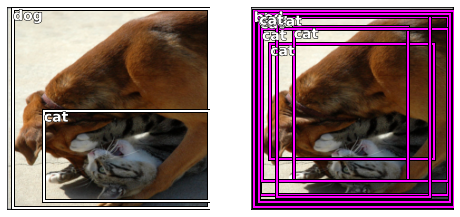

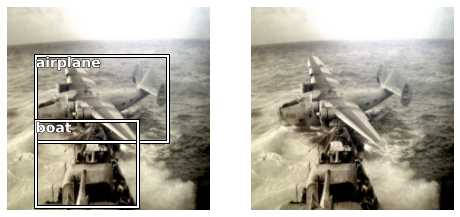

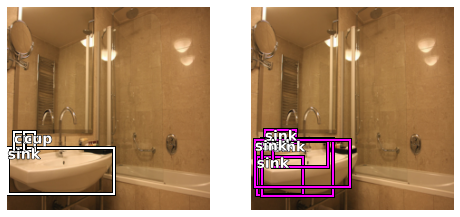

In [ ]:
more_learner = load_learner('models/20201110_coco_ssd_loss54.pkl')
more_results = ResultShower(dls, more_learner, anchors.cpu(), box_size.cpu())
more_results(3)

# Focal Loss

## New code

In [ ]:
class FocalLoss(BCE_Loss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

## Training

### Init anchors

In [ ]:
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

### Init model & train

In [ ]:
# # JH trains his final model at 1:51:26
# ### init loss
# bb_loss  = mae
# lbl_loss = FocalLoss(len(dls.vocab))

# ### init learner
# body = create_body(resnet34, pretrained=True)
# head = SSD_MultiHead(k, -4., drop=.4)
# mod  = Custom_Module(body, head)
# learner = Learner(dls.cuda(), mod, loss_func=ssd_loss) # Fix ResultShower to remove .cuda.
# learner.freeze_to(-2)
# lr_min,lr_max = learner.lr_find()

In [ ]:
# learner.fit_one_cycle(3, lr=3e-3)
# learner.save('ssd-focal-1')

# learner.unfreeze()
# learner.fit_one_cycle(5, slice(1e-6,1e-4))
# learner.save('ssd-focal-2')

# learner.export('models/20201110_coco_focal_deep.pkl')

epoch,train_loss,valid_loss,time
0,68.855476,67.512016,02:25
1,61.230110,59.043839,02:25
2,54.850395,55.170189,02:25


epoch,train_loss,valid_loss,time
0,54.225925,54.931396,02:25
1,53.047329,54.138756,02:25
2,50.574490,53.508873,02:25
3,49.886860,53.261360,02:26
4,49.327118,53.305119,02:26


**Trained & exported models:**
- 2020-11-10: `'models/20201027_bboxes_C2018_L9-20201110_ssdfocal_loss60.pkl'`
    - valid loss: 60
    - 5 epochs at 3e-3; all but last layer frozen (I think)
- 2020-11-10: `'models/20201110_coco_focal_deep.pkl'`
    - valid loss: 53
    - `learner.freeze_to(-2)`
    - `learner.fit_one_cycle(3, lr=3e-3)`
    - `learner.unfreeze()`
    - `learner.fit_one_cycle(5, slice(1e-6,1e-4))`

## Results for focal loss

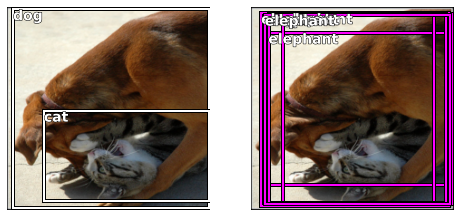

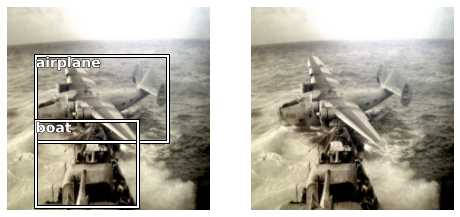

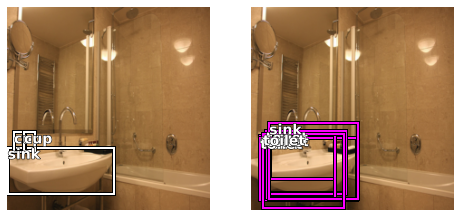

In [ ]:
focal_learner = load_learner('models/20201110_coco_focal_deep.pkl')
focal_results = ResultShower(dls, focal_learner, anchors.cpu(), box_size.cpu())
focal_results(3)